In [1]:
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import glob
from ast import literal_eval
from statistics import mean
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
import matplotlib
print(matplotlib.matplotlib_fname())
print(matplotlib.get_cachedir())

/root/anaconda3/envs/llumnix/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc
/root/.cache/matplotlib


## 查看instance.csv

In [3]:


def plot_metrics_according_filename(filename, metric, ax, label):
    instance_log = pd.read_csv(filename)
    # 删除dispatch_load_metric为-inf的行
    instance_log = instance_log[instance_log['dispatch_load_metric'] != -np.inf]
    # 将某一列中 "[0.0]" 类型的数据转换为 列表均值
    for _metric in [metric]:
        instance_log[_metric] = instance_log[_metric].apply(
            lambda x: x[0] if isinstance(x, list) and len(x) == 1 else (mean(literal_eval(x)) if isinstance(x, str) and x.startswith('[') else x)
        )
    instance_log.groupby("instance_id")
    instance_log_group = instance_log.groupby("instance_id")
    for i,instance_data in enumerate(instance_log_group):
        instance_id, group = instance_data
        metric_tmp = group[metric]
        ax[i].plot(group["timestamp"], metric_tmp, label=f'{label}-{instance_id}-{group["inference_type"].iloc[0]}')
        ax[i].set_ylabel(metric)
        # 标记均值（具体数值）
        mean_value = metric_tmp.mean()
        ax[i].text(group["timestamp"].mean(), mean_value*1.01, f'mean: {mean_value:.2f}', ha='center', va='bottom', fontsize=8)
        ax[i].legend()
def plot_instance_metric_in_different_instance(log_dir, tp, instance_num, metric, axes, req_num=1000, qps=None):    
    log_filename = f'serve_{instance_num}_tp{tp}_{req_num}_qps_{qps}_instance.csv'
    plot_metrics_according_filename(os.path.join(log_dir, log_filename), metric, axes[:instance_num], f'{instance_num}-instance')

    for prefill_num in range(1, instance_num):
        decede_num = instance_num - prefill_num
        log_filename = f'serve_pdd_tp{tp}_{req_num}_qps_{qps}_{prefill_num}_{decede_num}_instance.csv'
        plot_metrics_according_filename(os.path.join(log_dir, log_filename), metric, axes[prefill_num*instance_num:(prefill_num+1)*instance_num], f'{instance_num}-instance-pdd-{prefill_num}-{decede_num}')


def plot_instance_metric(log_dir, model, distribution, tp, instance_num, metric, req_num=1000, qps=None):
    log_dir = os.path.join(log_dir, f'{model}/{distribution}')

    num_rows = instance_num
    
    fig, axes = plt.subplots(instance_num, num_rows, figsize=(instance_num*7, num_rows*4.8))
    axes = axes.flatten()  # 将二维数组展平为一维数组
    print(f"metric : {metric}")
    plot_instance_metric_in_different_instance(log_dir, tp, instance_num, metric, axes, req_num=req_num, qps=qps)

    fig_filename_title = f"{model}-{distribution}-tp_{tp}_{req_num}_qps_{qps}-instanceNum_{instance_num}_L40_{metric}"
    fig.suptitle(fig_filename_title, fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    fig.savefig(fig_filename_title + ".png")
    plt.close(fig)
    


metric : gpu_cache_usage


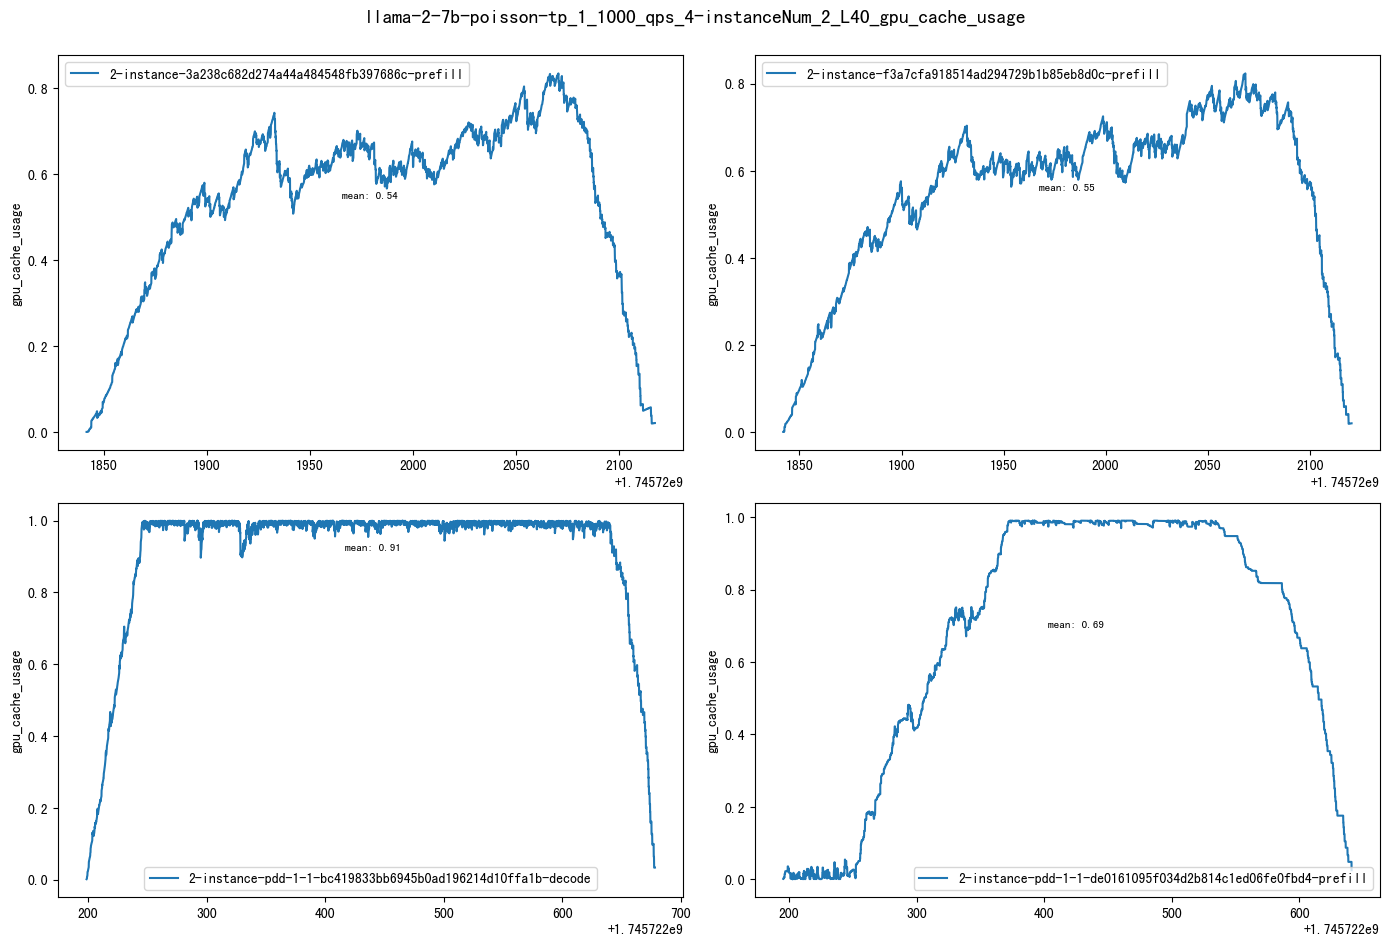

metric : num_available_gpu_blocks


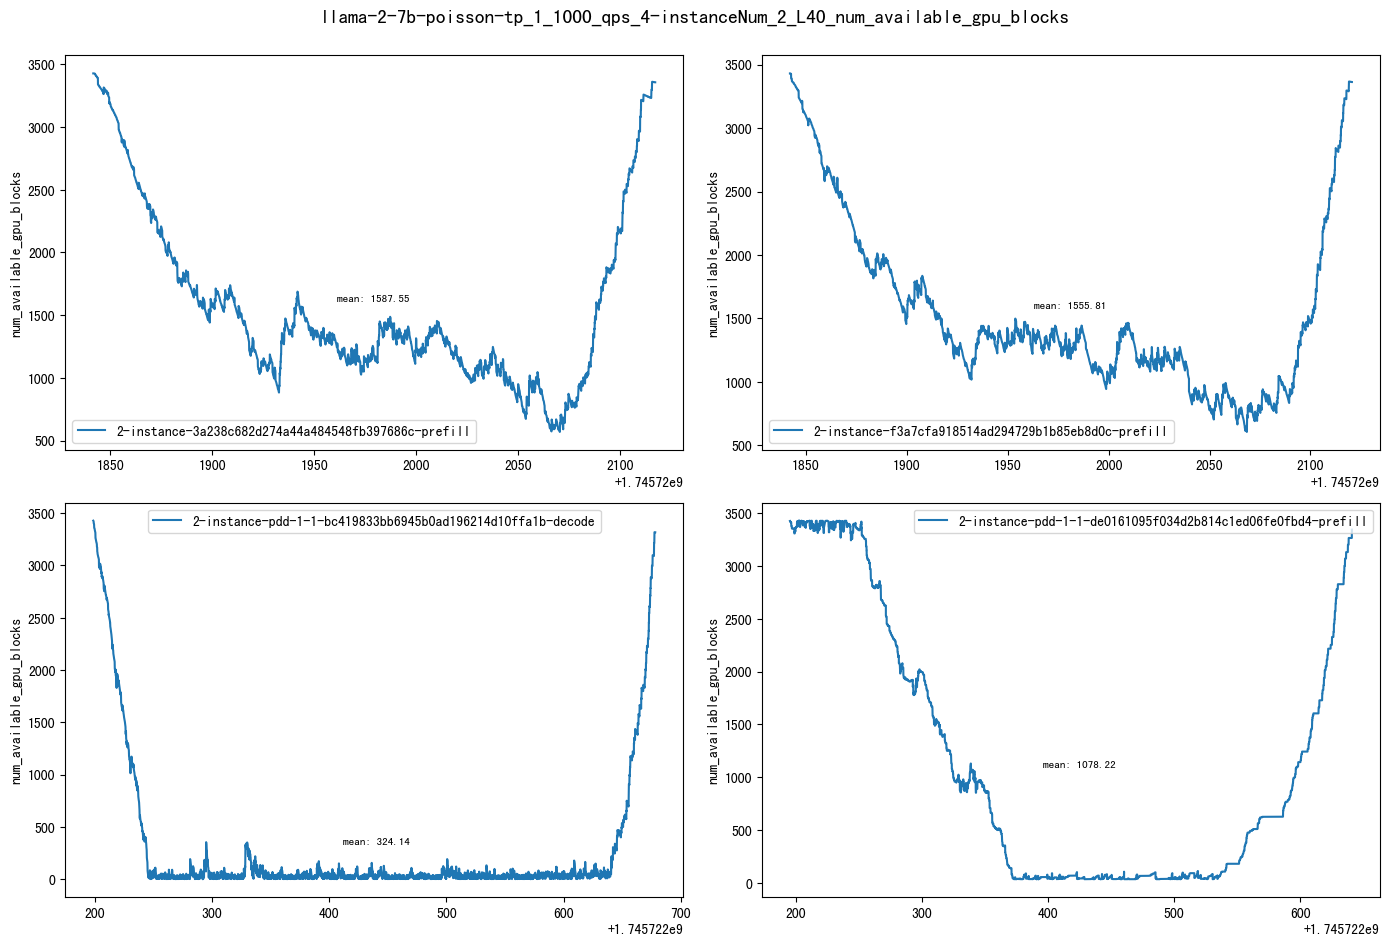

metric : dispatch_load_metric


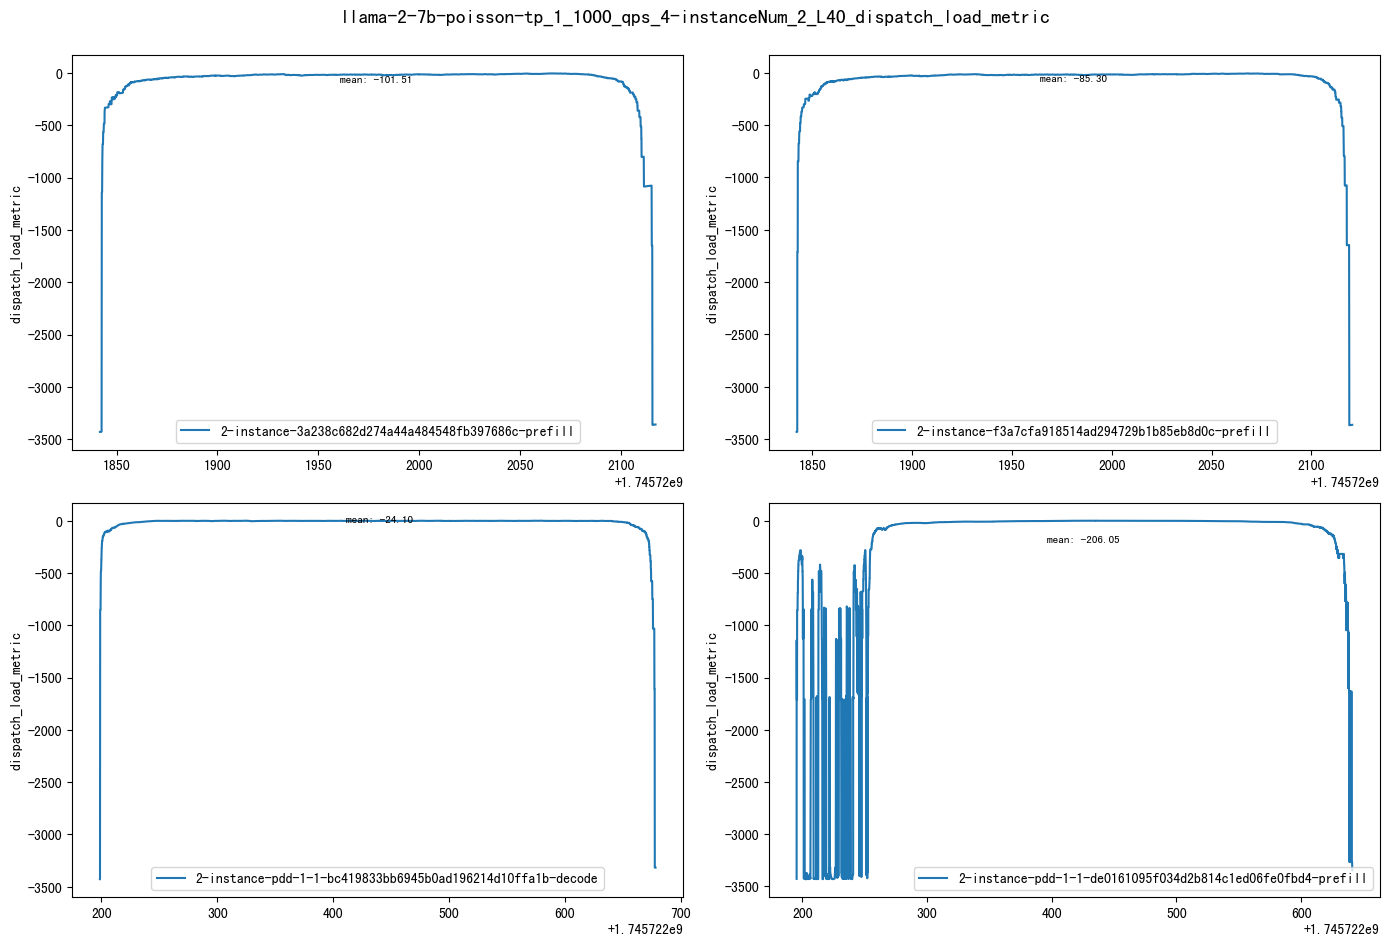

metric : migration_load_metric


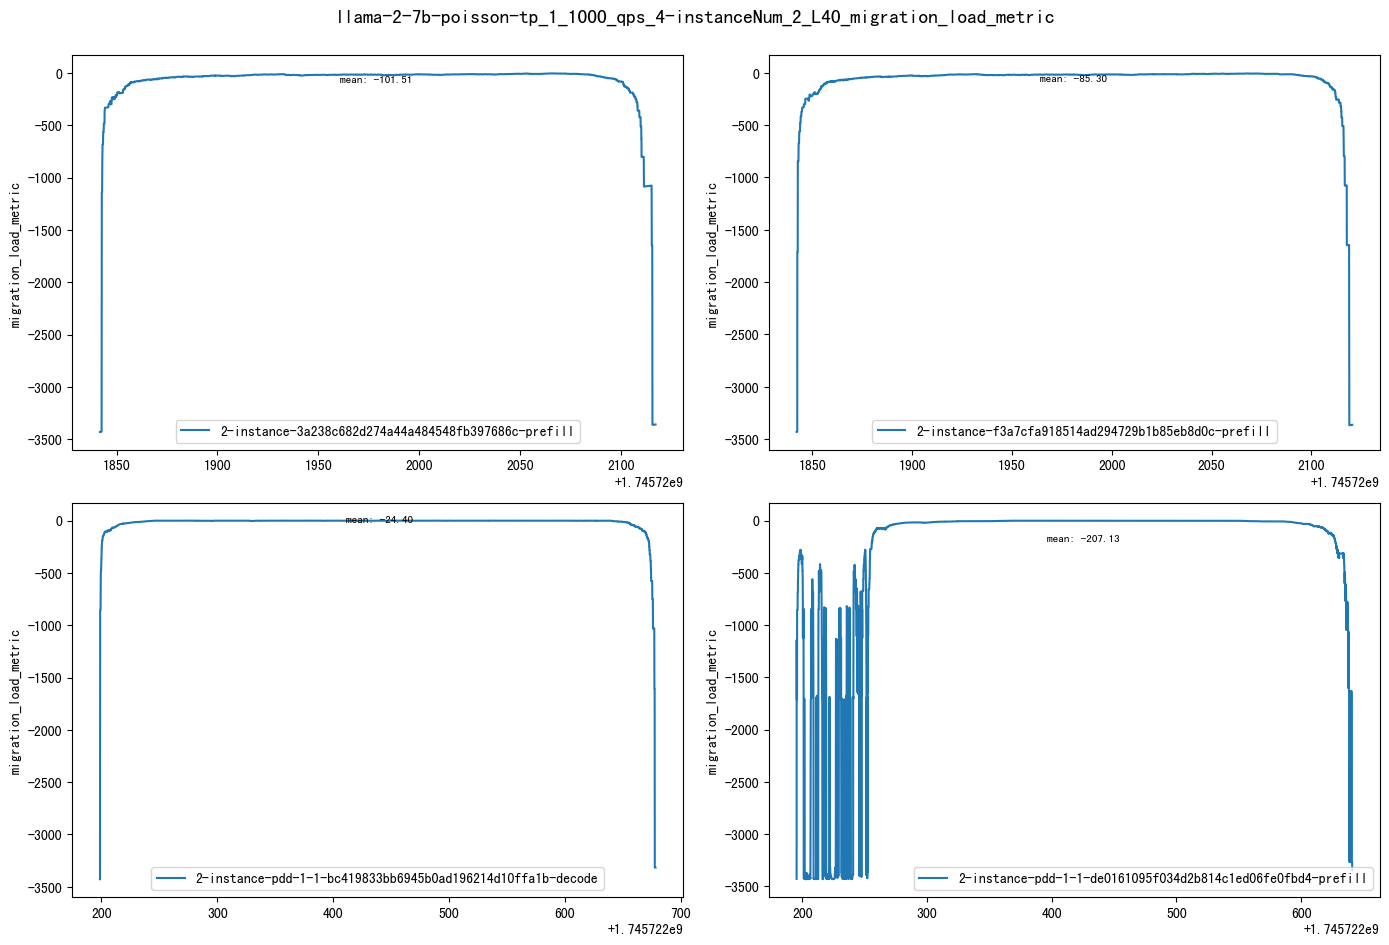

metric : num_running_requests


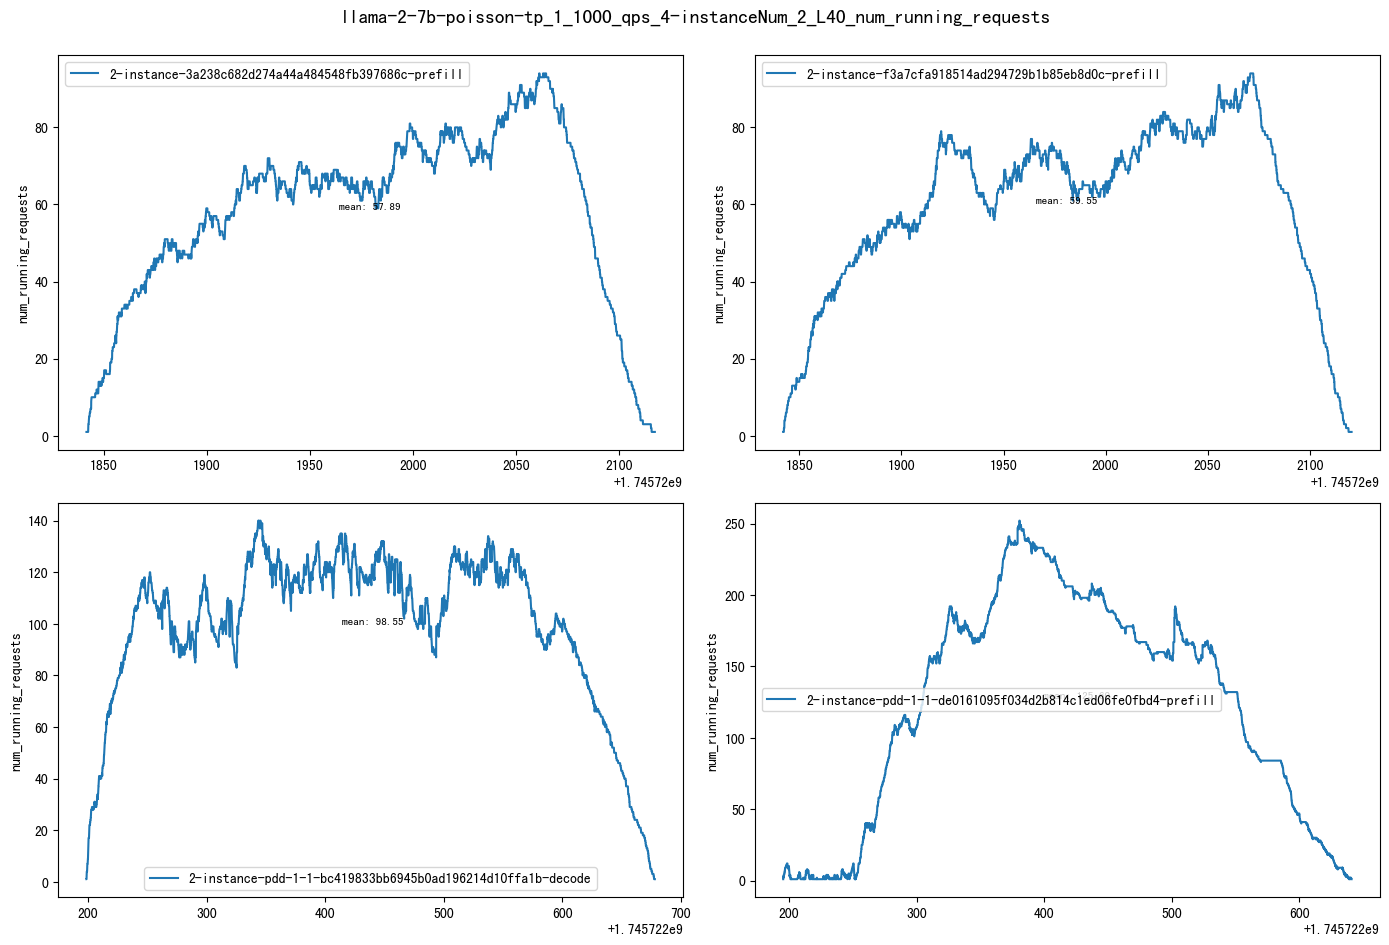

metric : num_waiting_requests


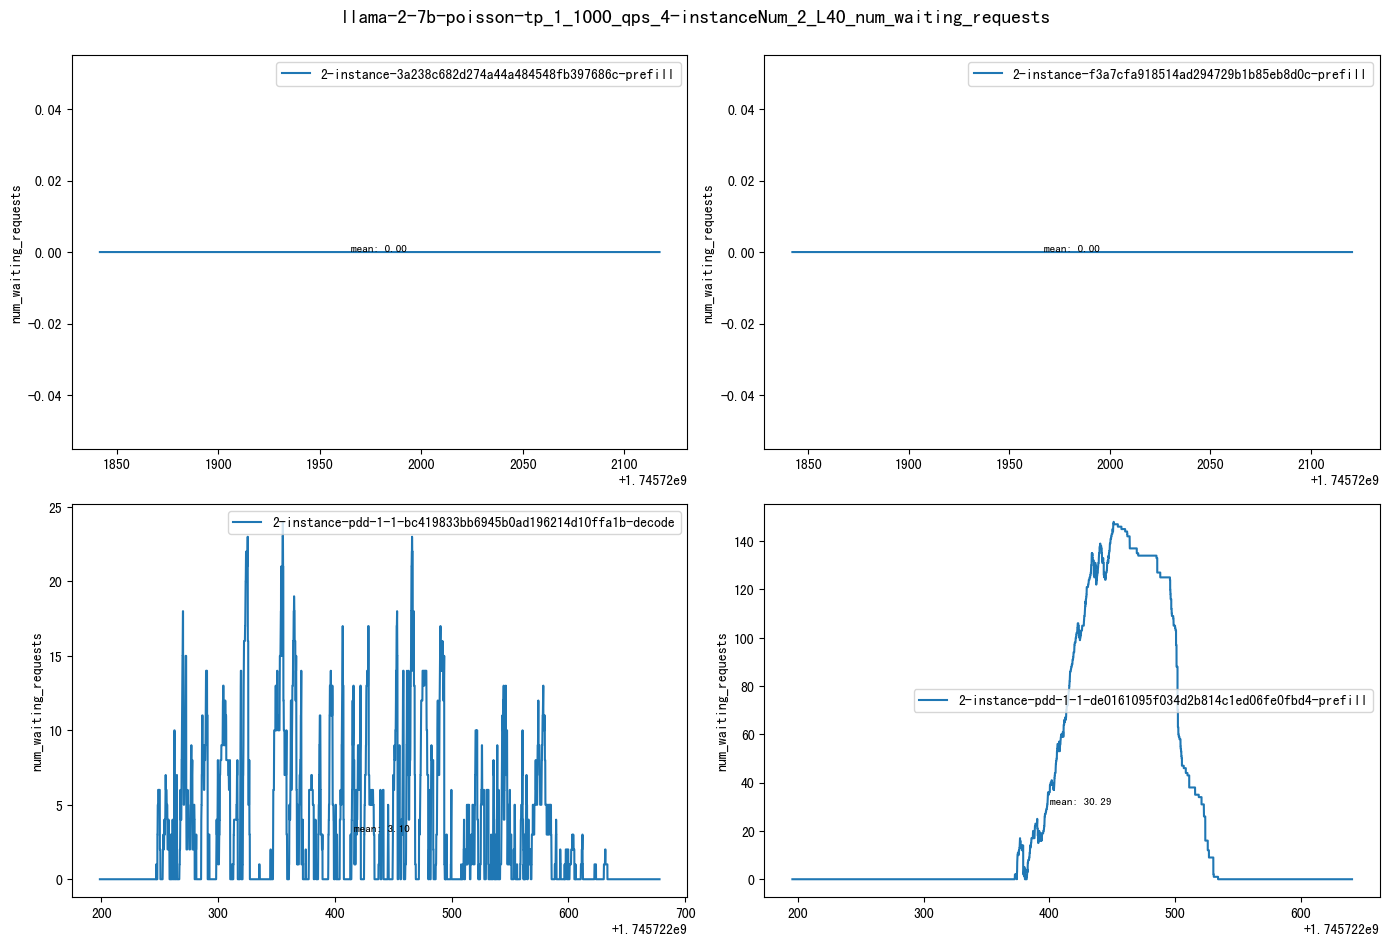

metric : num_killed_requests


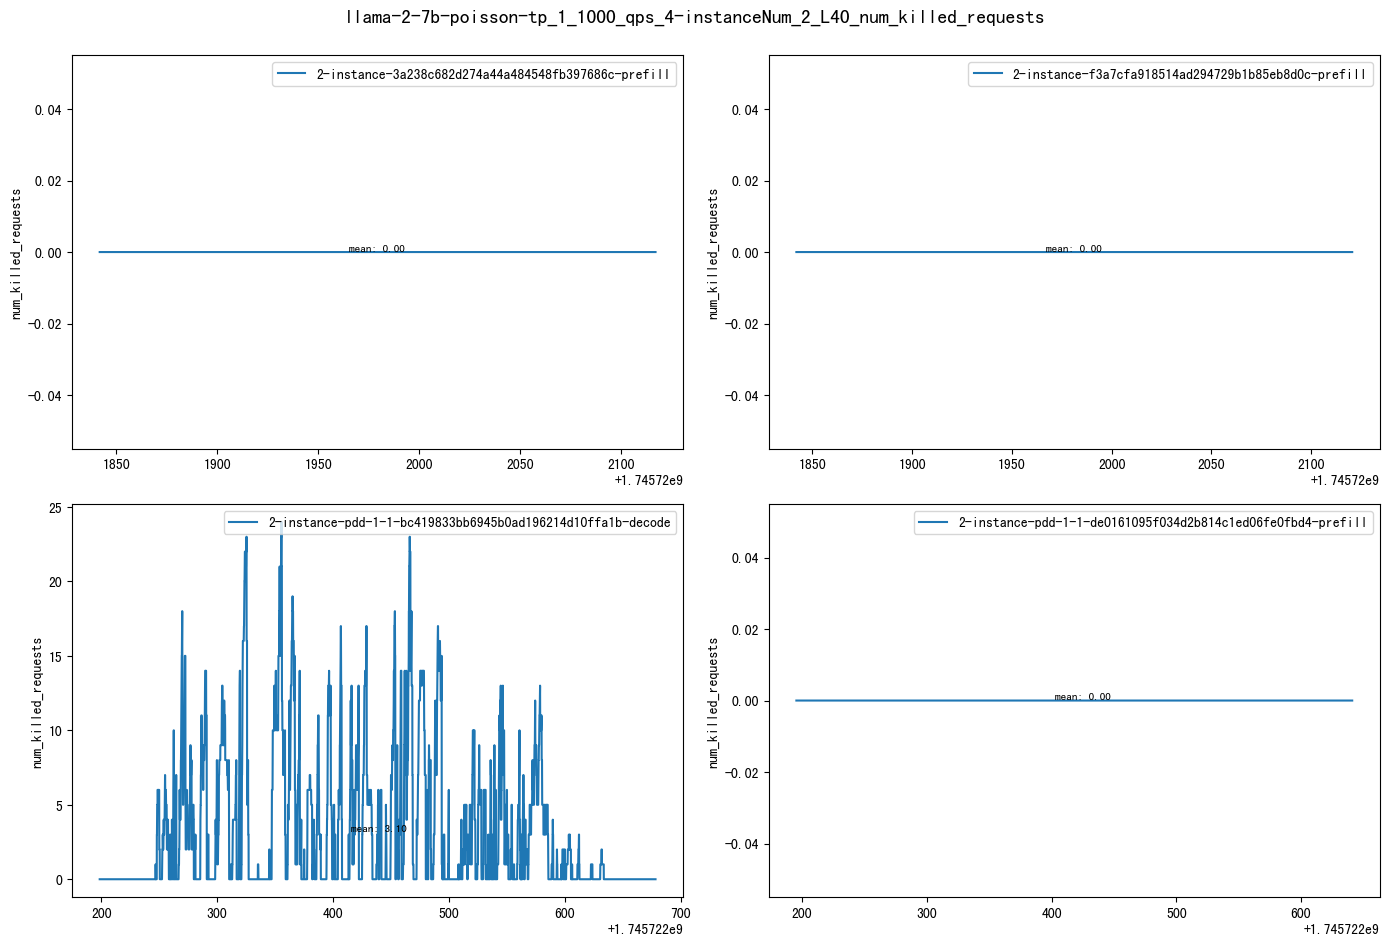

In [4]:
metrics = ["gpu_cache_usage", "num_available_gpu_blocks","dispatch_load_metric","migration_load_metric","num_running_requests","num_waiting_requests","num_killed_requests",]
model='llama-2-7b'
distribution= 'poisson'       # 'poisson' "uniform" 
sm_clocks = ["2490",]
mem_clocks = [9001]
tp = 1
instance_num = 2
req_num = 1000
log_dir = f'/workspace/llm-serve/Llumnix/logs/l40-pdd-{instance_num}'
for metric in metrics:
    plot_instance_metric(log_dir,model,distribution,tp,instance_num,metric,req_num, qps=4)

## 查看时延

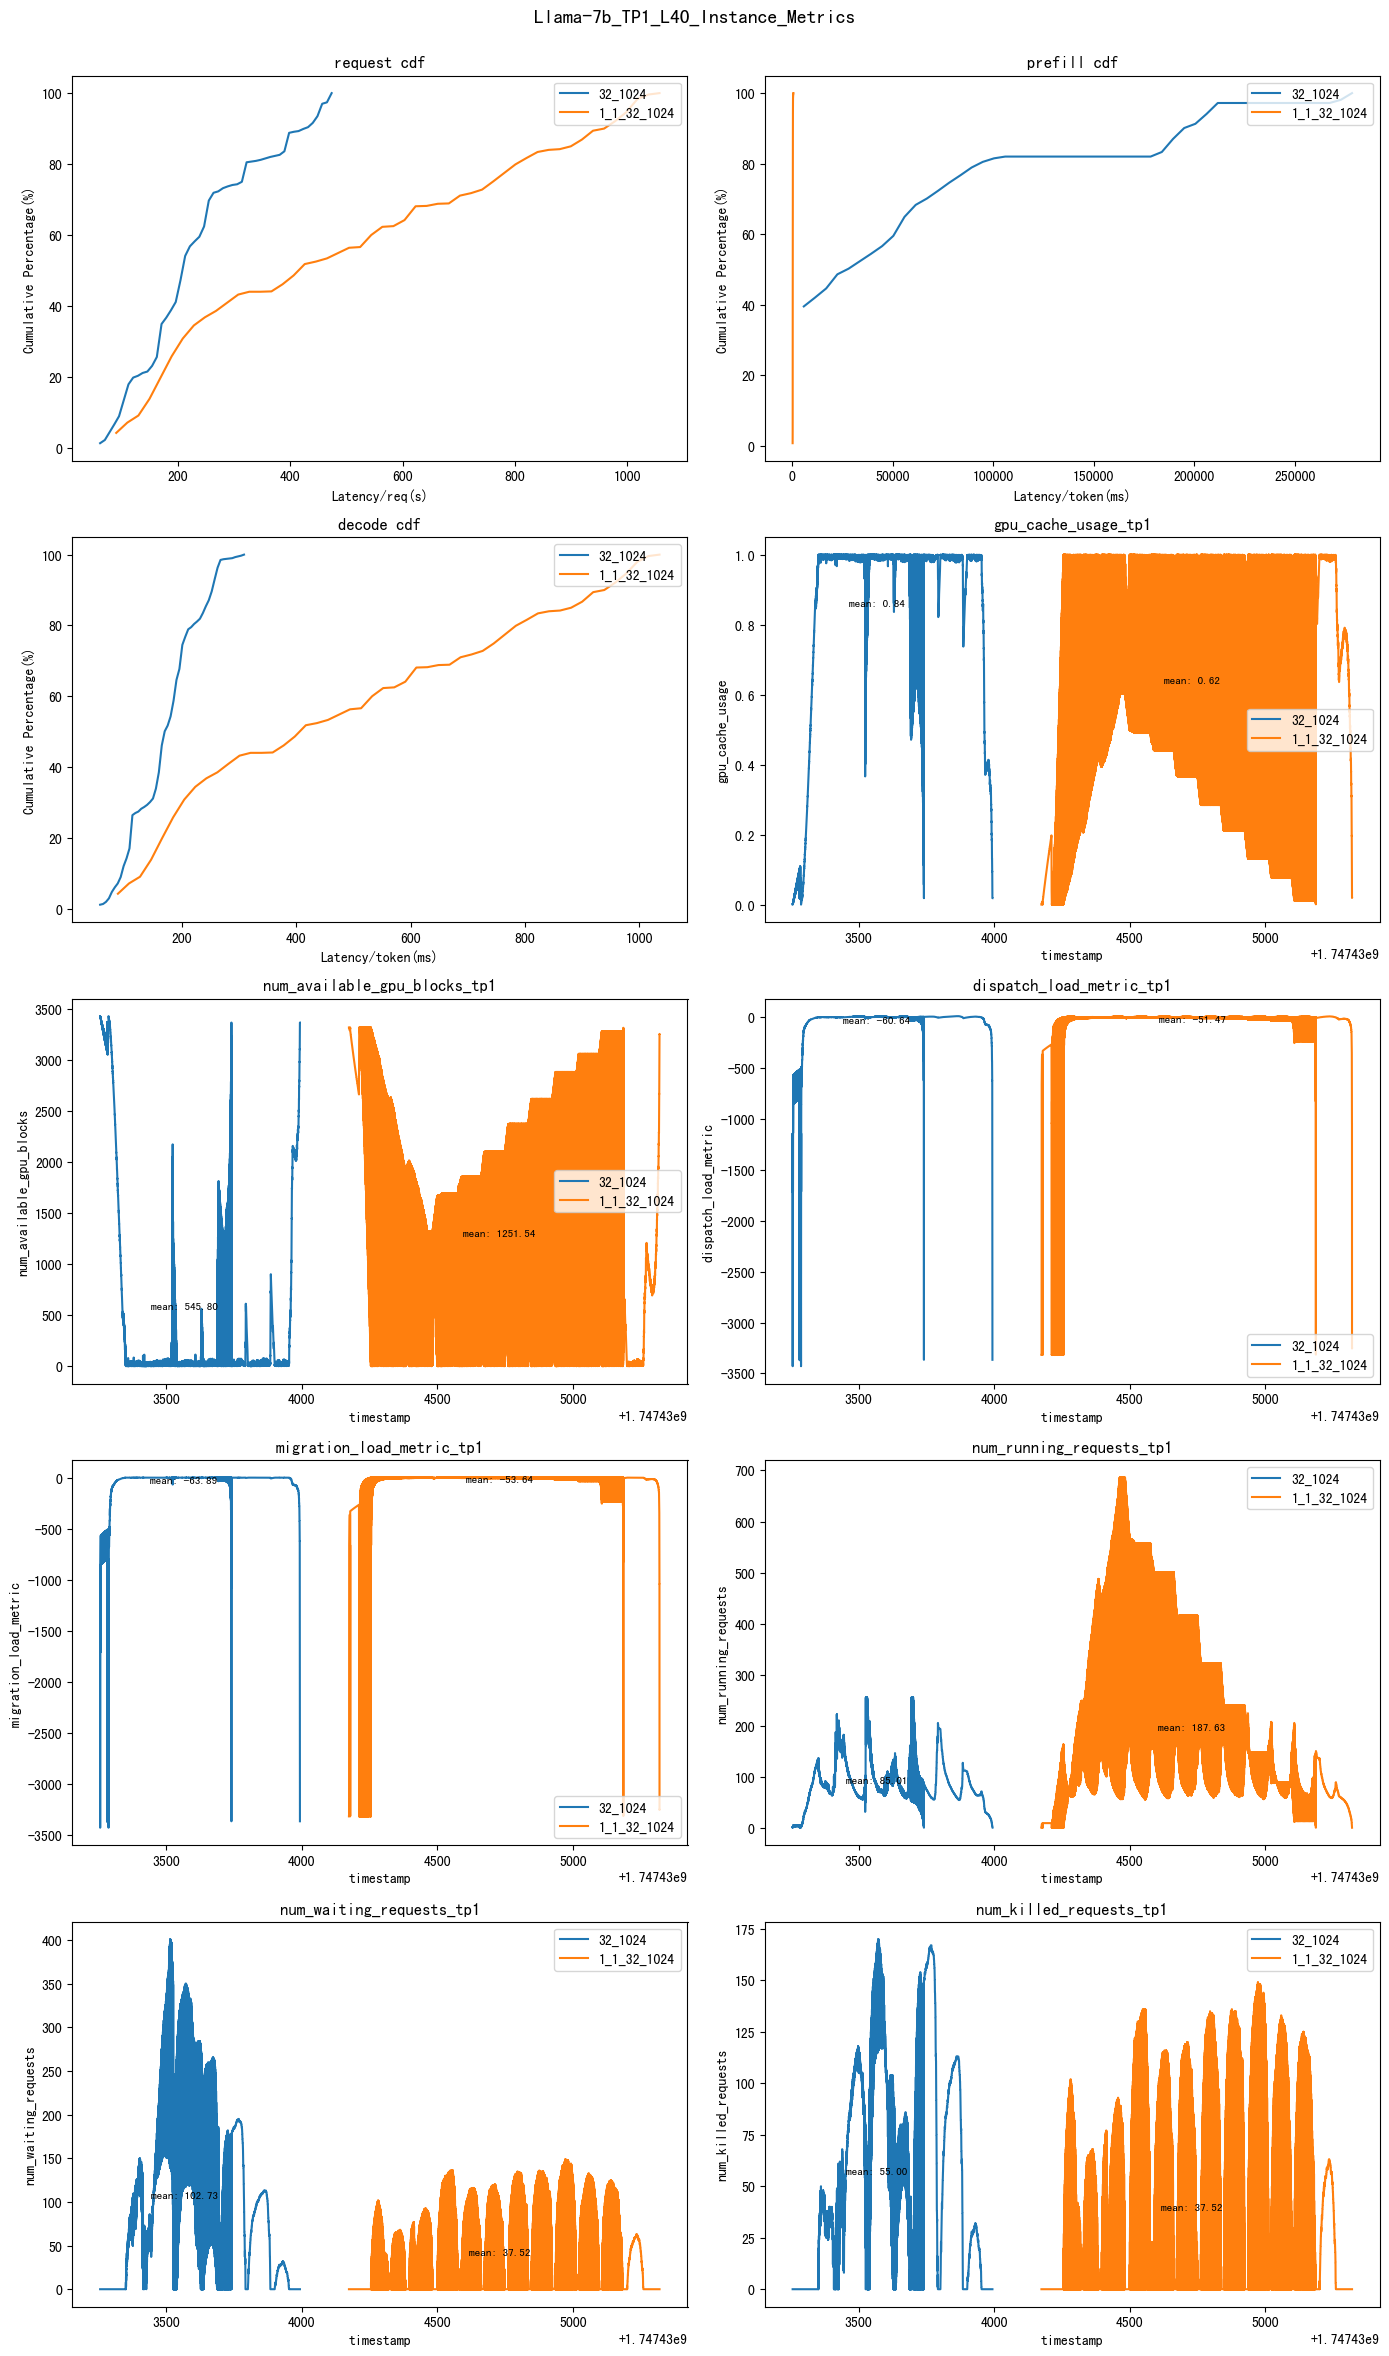

In [12]:
def plot_single(ax, data, prompt_len, response_len, label_prefix=''):
    hist, bin_edges = np.histogram(data, bins=50)
    cumsum = np.cumsum(hist)
    label = f'{label_prefix}_{prompt_len}_{response_len}' if label_prefix !='' else f'{prompt_len}_{response_len}'
    ax.plot(bin_edges[1:], cumsum/np.sum(hist)*100, label=label)
    ax.set_ylabel('Cumulative Percentage(%)')

def plot_three_latency_cdf_according_filename(log_filename, axes, prompt_len, response_len, label_prefix=''):
    (ax_req, ax_prefill, ax_decode) = axes
    latencies = json.load(open(log_filename, 'r'))[0]
    req_latencies, prefill_latencies, decode_latencies = latencies['request_latencies'], latencies['prefill_token_latencies'], latencies['decode_token_latencies']

    plot_single(ax_req, req_latencies, prompt_len, response_len, label_prefix)
    plot_single(ax_prefill, prefill_latencies, prompt_len, response_len, label_prefix)
    plot_single(ax_decode, decode_latencies, prompt_len, response_len, label_prefix)

def plot_latency_cdf(log_dir, tps, prompt_lens, response_lens, req_num, qps, instance_num, axes):
    (ax_req, ax_prefill, ax_decode) = axes
    # 判断tps是不是list，不是就转为list
    if not isinstance(tps, list):
        tps = [tps]
    for tp in tps:
        for prompt_len in prompt_lens:
            for response_len in response_lens:
                log_filename = f'benchmark_{instance_num}_tp{tp}_{req_num}_qps_{qps}_prompt_len_{prompt_len}_response_len_{response_len}_latency_info.json'
                log_filename = os.path.join(log_dir, log_filename)
                plot_three_latency_cdf_according_filename(log_filename, axes, prompt_len, response_len)
                for prefill_num in range(1, instance_num):
                    decede_num = instance_num - prefill_num
                    log_filename = f'benchmark_pdd_tp{tp}_{req_num}_qps_{qps}_prompt_len_{prompt_len}_response_len_{response_len}_{prefill_num}_{decede_num}_latency_info.json'
                    log_filename = os.path.join(log_dir, log_filename)
                    plot_three_latency_cdf_according_filename(log_filename, axes, prompt_len, response_len, label_prefix=f'{prefill_num}_{decede_num}')

    ax_req.set_xlabel('Latency/req(s)')
    ax_req.set_ylabel('Cumulative Percentage(%)')
    ax_req.set_title('request cdf')
    ax_req.legend(loc='upper right')
    ax_prefill.set_xlabel('Latency/token(ms)')
    ax_prefill.set_ylabel('Cumulative Percentage(%)')
    ax_prefill.set_title('prefill cdf')
    ax_prefill.legend(loc='upper right')
    ax_decode.set_xlabel('Latency/token(ms)')
    ax_decode.set_ylabel('Cumulative Percentage(%)')
    ax_decode.set_title('decode cdf')
    ax_decode.legend(loc='upper right')

def plot_metrics_cdf_according_filename(log_filename,prompt_len, response_len, axes, metrics, label_prefix=''):
    instance_log = pd.read_csv(log_filename)

    # 删除dispatch_load_metric为-inf的行
    instance_log = instance_log[instance_log['dispatch_load_metric'] != -np.inf]
    # 将某一列中 "[0.0]" 类型的数据转换为 列表均值
    for metric in metrics:
        instance_log[metric] = instance_log[metric].apply(
            lambda x: x[0] if isinstance(x, list) and len(x) == 1 else (mean(literal_eval(x)) if isinstance(x, str) and x.startswith('[') else x)
        )


        # ax.set_legend([f'{sm_clock}_{mem_clock}'])
    for i, metric in enumerate(metrics):
        metric_tmp = instance_log[metric]
        label = f'{label_prefix}_{prompt_len}_{response_len}' if label_prefix !='' else f'{prompt_len}_{response_len}'
        axes[i].plot(instance_log["timestamp"], metric_tmp, label=label)
        axes[i].set_ylabel(metric)
        # 标记均值（具体数值）
        mean_value = metric_tmp.mean()
        # axes[i].axhline(mean_value, linestyle='--', label=f'{sm_clock}_{mem_clock} mean')
        if "timestamp" in instance_log.columns and not instance_log["timestamp"].empty:
            midpoint_value = instance_log["timestamp"].iloc[len(instance_log["timestamp"]) // 2]
            # print(midpoint_value)
        else:
            print("The timestamp column is either missing or empty.")

        axes[i].text(midpoint_value, mean_value*1.01, f'mean: {mean_value:.2f}', ha='center', va='bottom', fontsize=8)
        # axes[i].axhline(mean_value, linestyle='--', )
        # plot_single(axes[i], metric_tmp, sm_clock, mem_clock)

def plot_pdd_instance_log_cdf(log_dir, tps, prompt_lens, response_lens, metrics, req_num=100, qps=4, instance_num=2):
    # 根据metrics数设置图的数量，2个图一行
    num_metrics = len(metrics) + 3
    num_rows = (num_metrics + 1) // 2
    
    for tp in tps:
        fig, axes = plt.subplots(num_rows, 2, figsize=(2*7, num_rows*4.8))
        axes = axes.flatten()  # 将二维数组展平为一维数组
        latency_axes = axes[:3]  # 前三个子图用于延迟
        axes = axes[3:]  # 剩余的子图用于其他指标
        for prompt_len in prompt_lens:
            for response_len in response_lens:
                log_filename = f'serve_{instance_num}_tp{tp}_{req_num}_qps_{qps}_prompt_len_{prompt_len}_response_len_{response_len}_instance.csv'
                log_filename = os.path.join(log_dir, log_filename)
                plot_metrics_cdf_according_filename(log_filename, prompt_len, response_len, axes, metrics)
                for prefill_num in range(1, instance_num):
                    decede_num = instance_num - prefill_num
                    log_filename = f'serve_pdd_tp{tp}_{req_num}_qps_{qps}_{prefill_num}_{decede_num}_prompt_len_{prompt_len}_response_len_{response_len}_instance.csv'
                    log_filename = os.path.join(log_dir, log_filename)
                    plot_metrics_cdf_according_filename(log_filename, prompt_len, response_len, axes, metrics, f'{prefill_num}_{decede_num}')

        for i, metric in enumerate(metrics):
            axes[i].set_xlabel("timestamp")
            axes[i].set_ylabel(metric)
            axes[i].set_title(f'{metric}_tp{tp}')
            axes[i].legend()
        # 处理 latencies 三个子图
        plot_latency_cdf(log_dir, tp, prompt_lens, response_lens, req_num, qps, instance_num, latency_axes,)
        fig_filename_title = f"Llama-7b_TP{tp}_L40_Instance_Metrics"
        fig.suptitle(fig_filename_title, fontsize=14)
        fig.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
        fig.savefig(fig_filename_title + ".png")
        plt.close(fig)
    
gpu_metrics = ["power", "sm_clock","mem_clock","gr_engine_active","sm_active","sm_occupancy","tensor_active","dram_active","fp32_active","fp16_active","pcie_tx_bytes","pcie_rx_bytes","nvlink_tx_bytes","nvlink_rx_bytes",]
    
metrics = ["gpu_cache_usage", "num_available_gpu_blocks","dispatch_load_metric","migration_load_metric","num_running_requests","num_waiting_requests","num_killed_requests",]
model='llama-2-7b'
distribution= 'poisson'       # 'poisson' "uniform" 
prompt_lens = [32, ]     # [32, 64, 128, 256, 512, 1024]
response_lens = [ 1024]
tp = 1
req_num = 1000
qps = 4
instance_num = 2
migrate_backend = 'nccl'    # rayrpc
log_dir = f'/workspace/llm-serve/Llumnix/logs/l40-pdd---{instance_num}/{model}/{distribution}/' + migrate_backend
plot_pdd_instance_log_cdf(log_dir,[1],prompt_lens,response_lens,metrics,req_num,qps,instance_num)


## 基于prompt_len和response_len绘制热力图

In [18]:
# 获取不同prompts和responses的latency
def get_latency(log_dir, prompt_len, response_len, req_num, qps, instance_num, prefill_num=0, decede_num=0):
    if prefill_num == 0 and decede_num == 0:
        log_filename = f'benchmark_{instance_num}_tp{tp}_{req_num}_qps_{qps}_prompt_len_{prompt_len}_response_len_{response_len}_latency_info.json'
    else:
        log_filename = f'benchmark_pdd_tp{tp}_{req_num}_qps_{qps}_prompt_len_{prompt_len}_response_len_{response_len}_{prefill_num}_{decede_num}_latency_info.json'
    log_filename = os.path.join(log_dir, log_filename)
    with open(log_filename, 'r') as f:
        return json.load(f)[0]

def get_latency_mean(latencies):
    req_latencies, prefill_latencies, decode_latencies = latencies['request_latencies'], latencies['prefill_token_latencies'], latencies['decode_token_latencies']
    return np.mean(req_latencies), np.mean(prefill_latencies), np.mean(decode_latencies)
# 画出latency的热力图，不同prefill_num的热力图排成一行
def plot_heatmap(data, title, x_labels, y_labels, ax, origin_data = None):
    cax = ax.matshow(data, cmap='hot')
    cax.set_cmap('jet')
    plt.colorbar(cax)
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Response Length')
    ax.set_ylabel('Prompt Length')
    ax.set_title(title)
    # 在每个单元格中添加文本,同时判断是否大于origin_data
    for (i, j), val in np.ndenumerate(data):
        if origin_data is not None and val < origin_data[i,j]:
            ax.text(j, i, f'{val:.2f}(*)', ha='center', va='center', color='white', fontsize=9)
        else:
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white', fontsize=9)


In [ ]:

prompt_lens = [32, 64, 128, 256, 512, 1024]     # [32, 64, 128, 256, 512, 1024]
response_lens = [32, 64, 128, 256, 512, 1024]
instance_num = 4
latency = np.zeros((len(prompt_lens), len(response_lens), 3*instance_num))
tp = 1
req_num = 1000
qps = 4
model='llama-2-7b'
distribution= 'poisson'
migrate_backend = 'rayrpc'
log_dir = f'/workspace/llm-serve/Llumnix/logs/l40-pdd---{instance_num}/{model}/{distribution}/{migrate_backend}'
for i, prompt_len in enumerate(prompt_lens):
    for j, response_len in enumerate(response_lens):
        latencies = get_latency(log_dir, prompt_len, response_len, req_num, qps, instance_num)
        latency[i][j][:3] = get_latency_mean(latencies)
        for prefill_num in range(1, instance_num):
            decede_num = instance_num - prefill_num
            latencies = get_latency(log_dir, prompt_len, response_len, req_num, qps, instance_num, prefill_num, decede_num)
            latency[i][j][prefill_num*3:(prefill_num+1)*3] = get_latency_mean(latencies)
        # print(f"prompt_len: {prompt_len}, response_len: {response_len}, latency: {latency[i][j]}")

type_labels = ['request', 'prefill', 'decode']
fig, axes = plt.subplots(instance_num, 3, figsize=(3*7, instance_num*4.8, ))
axes = axes.flatten()  # 将二维数组展平为一维数组

for i in range(instance_num):
    for t in range(3):
        data = latency[:, :, i*3+t]
        title = f'Latency Heatmap (Prefill Num: {i}, Type: {type_labels[t]})'
        ax = axes[i*3+t]
        plot_heatmap(data, title, response_lens, prompt_lens, ax, latency[:, :, t])
        ax.set_xlabel('Response Length')
        ax.set_ylabel('Prompt Length')
        ax.set_title(title)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
fig.savefig("Latency_Heatmap.png")
plt.close(fig)
    



## 获取所有请求的各阶段时间
+ 所有token的decode时间，以及请求的迁移时间、等待时间
    + request_id, prefill_time, migration_waiting_time, migration_time, decode_token_1, ...

In [2]:
import re
def plot_single(ax, latencies):
    hist, bin_edges = np.histogram(latencies, bins=50)
    cumsum = np.cumsum(hist)
    p50 = np.percentile(latencies, 50)
    p80 = np.percentile(latencies, 80)
    p95 = np.percentile(latencies, 95)
    p99 = np.percentile(latencies, 99)
    p999 = np.percentile(latencies, 99.9)
    ax.plot(bin_edges[1:], cumsum/np.sum(hist)*100, color='red')
    ax.axvline(p50, color='blue', linestyle='--', label='P50')
    ax.text(p50, ax.get_ylim()[0] + 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0]), f"{p50:.2f}", va='bottom', ha='right', color='blue')
    ax.axvline(p80, color='green', linestyle='--', label='P80')
    ax.text(p80, ax.get_ylim()[0] + 0.10 * (ax.get_ylim()[1] - ax.get_ylim()[0]), f"{p80:.2f}", va='bottom', ha='right', color='green')
    ax.axvline(p95, color='orange', linestyle='--', label='P95')
    ax.text(p95, ax.get_ylim()[0] + 0.15 * (ax.get_ylim()[1] - ax.get_ylim()[0]), f"{p95:.2f}", va='bottom', ha='right', color='orange')
    ax.axvline(p99, color='purple', linestyle='--', label='P99')
    ax.text(p99, ax.get_ylim()[0] + 0.20 * (ax.get_ylim()[1] - ax.get_ylim()[0]), f"{p99:.2f}", va='bottom', ha='right', color='purple')
    ax.axvline(p999, color='gray', linestyle='--', label='P99.9')
    ax.text(p999, ax.get_ylim()[0] + 0.25 * (ax.get_ylim()[1] - ax.get_ylim()[0]), f"{p999:.2f}", va='bottom', ha='right', color='gray')
    mean = np.mean(latencies)
    mean_value = bin_edges[:-1][np.where(bin_edges[:-1] <= mean)][-1]
    mean_percentage = cumsum[np.where(bin_edges[:-1] <= mean)][-1] / np.sum(hist) * 100
    ax.axvline(mean_value, color='black', linestyle='-', label='mean={:.2f}'.format(mean))
    ax.text(mean_value, mean_percentage, f"{mean_percentage:.2f}", va='bottom', ha='right', color='black')
    ax.legend(loc='upper right')
    ax.set_ylabel('Cumulative Percentage(%)')
def extract_migration_times(path):
    # 检查文件是否存在
    if not os.path.isfile(path):
        print(f"File {path} does not exist.")
        return {}
    # 初始化结果字典
    migration_times = {}

    # 正则表达式模式（保持不变）
    pattern = r'migrate request \[(.*?)\].*?cost: (\d+\.\d+) ms'

    # 逐行读取文件（自动处理大文件）
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            # 直接处理每行（更高效）
            line = line.strip()  # 移除首尾空白字符
            if 'migrate done' in line and 'cost:' in line:
                match = re.search(pattern, line)
                if match:
                    # 提取请求ID和时间（逻辑不变）
                    ids_str = match.group(1)
                    time = float(match.group(2))
                    request_ids = [req_id.strip("'") for req_id in ids_str.split(', ')]
                    # 更新字典
                    for req_id in request_ids:
                        migration_times[req_id] = time
    return migration_times

def extract_migration_waiting_times(log_file_path):
    # 定义一个字典，用于存储请求 ID 对应的时间戳
    request_timestamps = {}
    migrate_waiting_times = []
    # 打开日志文件并逐行读取
    with open(log_file_path, 'r') as file:
        for line in file:
            # 检查行是否包含 engine_step_timestamp_end 或 _migrate_out_one_request start
            if "engine_step_timestamp_end" in line or "_migrate_out_one_request start" in line:
                # 使用正则表达式提取请求 ID
                request_id_match = re.search(r'[0-9a-f]{32}', line)
                # 使用正则表达式提取时间戳
                timestamp_match = re.search(r'timestamps: \d+\.\d+', line)

                if request_id_match and timestamp_match:
                    request_id = request_id_match.group()
                    timestamp = float(timestamp_match.group().split(":")[1])

                    # 如果请求 ID 不在字典中，则初始化一个条目
                    if request_id not in request_timestamps:
                        request_timestamps[request_id] = {
                            "engine_step_timestamp_end": None,
                            "_migrate_out_one_request start": None
                        }

                    # 根据日志行内容更新对应的时间戳
                    if "engine_step_timestamp_end" in line:
                        request_timestamps[request_id]["engine_step_timestamp_end"] = timestamp
                    elif "_migrate_out_one_request start" in line:
                        request_timestamps[request_id]["_migrate_out_one_request start"] = timestamp
                    if request_timestamps[request_id]["_migrate_out_one_request start"] is not None and request_timestamps[request_id]["engine_step_timestamp_end"] is not None:
                        request_timestamps[request_id]["migrate_waiting_time"] = (request_timestamps[request_id]["_migrate_out_one_request start"] - request_timestamps[request_id]["engine_step_timestamp_end"]) *1000
                        request_timestamps[request_id]["migrate_waiting_time"] = max(0, request_timestamps[request_id]["migrate_waiting_time"])
                        migrate_waiting_times.append(request_timestamps[request_id]["migrate_waiting_time"])
    
    # if len(migrate_waiting_times) > 0:
    #     fig, (ax) = plt.subplots(1, 1, figsize=(7, 4.8))
    #     fig.suptitle(log_file_path, fontsize=14)
    #     plot_single(ax, migrate_waiting_times)
        
    return request_timestamps

# 读取一个json文件的指定字段
def json_to_decode_latencies(json_file, csv_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    # 提取指定字段
    token_latencies_list = data[0]['all_decode_token_latencies']
    response_lens = data[0]['request_lens']
    # token_latencies_list是一个list，response_lens保存了每个请求在token_latencies_list中对应的长度，基于response_lens将其转换为二维数组
    output_len_per_seq = max(response_lens)
    token_latencies = np.zeros((len(response_lens), output_len_per_seq))

    t=0
    for i in range(len(response_lens)):
        token_latencies[i][:response_lens[i]] = token_latencies_list[t:t+response_lens[i]]
        # assert token_latencies[i][0] != token_latencies[i][1], f"token_latencies[{i}][0]== token_latencies[{i}][1] = {token_latencies[i][0]} == {token_latencies[i][1]}"
        if token_latencies[i][0] == token_latencies[i][1]:
            print(f"token_latencies[{i}][0] == token_latencies[{i}][1] = {token_latencies[i][0]} == {token_latencies[i][1]}")
        t += response_lens[i]
    
    # 将数据转换为DataFrame，将request_ids作为index
    df = pd.DataFrame(token_latencies, index=data[0]['request_ids'])

    # 设置列名为token_id
    df.columns = [f'decode_token_{i+1}' for i in range(output_len_per_seq)]

    # 获取迁移时间
    if 'pdd' in json_file.split('/')[-1]:
        # 将'/workspace/llm-serve/Llumnix/logs/l40-pdd--2/llama-2-7b/poisson/benchmark_pdd_tp1_1000_qps_4_prompt_len_1024_response_len_64_1_1_latency_info.json'转化为'/workspace/llm-serve/Llumnix/logs/l40-pdd--2/llama-2-7b/poisson/benchmark_pdd_tp1_1000_qps_4_1_1_prompt_len_1024_response_len_64_latency_info.json'
        p_d = json_file[-22:-17]    # _1_1_
        tmp = json_file[:-22].split('qps_')
        tmp = tmp[0] + 'qps_' + tmp[1][0] + p_d + tmp[1][2:] + json_file[-17:]
        log_path = tmp.replace('latency_info.json', '.log')
        log_path = log_path.replace('benchmark', 'serve')
        
        migration_times = extract_migration_times(log_path)
        migration_waiting_times = extract_migration_waiting_times(log_path)
        # print(log_path,len(migration_times))

        # 在df中添加一列，列名为migration_time，放在第一列
        df.insert(0, 'migration_time', 0.0)
        df.insert(0, 'migration_waiting_time', 0.0)
        # 遍历df的index，获取对应的migration_time
        for index in df.index:
            # 如果index在migration_times中，则将对应的值赋值给df['migration_time']
            # print(index, index in migration_times)
            if index in migration_times:
                df.at[index, 'migration_time'] = migration_times[index]

            if index in migration_waiting_times and "migrate_waiting_time" in migration_waiting_times[index]:
                # print(migration_waiting_times[index])
                df.at[index, 'migration_waiting_time'] = migration_waiting_times[index]['migrate_waiting_time']

    # print(csv_file)
    df.insert(0, 'prefill_time', data[0]['prefill_token_latencies'])
    # 保存为csv文件
    df.to_csv(csv_file, index=True)
# filename = '/workspace/llm-serve/Llumnix/logs/l40-pdd-2/llama-2-7b/poisson/benchmark_2_tp1_1000_qps_4_prompt_len_1024_response_len_64_latency_info.json'
# filename = '/workspace/llm-serve/Llumnix/logs/l40-pdd--2/llama-2-7b/poisson/benchmark_pdd_tp1_1000_qps_4_prompt_len_1024_response_len_64_1_1_latency_info.json'
# filename = '/workspace/llm-serve/Llumnix/logs/l40-pdd--4/llama-2-7b/poisson/benchmark_4_tp1_1000_qps_4_prompt_len_64_response_len_512_latency_info.json'
# 读取某个目录下的所有json文件
# dir = '/workspace/llm-serve/Llumnix/logs/l40-pdd--4/llama-2-7b/poisson'
# dir = '/workspace/llm-serve/Llumnix/logs/l40-pdd--2/llama-2-7b/poisson'
migrate_backend = 'gloo'    # rayrpc,nccl,gloo
dir = '/workspace/llm-serve/Llumnix/logs/l40-pdd--2/llama-2-7b/uniform/' + migrate_backend
for filename in glob.glob(os.path.join(dir, '*.json')):
    # filename = '/workspace/llm-serve/Llumnix/logs/l40-pdd--2/llama-2-7b/poisson/benchmark_2_tp1_1000_qps_4_prompt_len_1024_response_len_64_latency_info.json'
    # filename = '/workspace/llm-serve/Llumnix/logs/l40-pdd--2/llama-2-7b/poisson/benchmark_pdd_tp1_1000_qps_4_prompt_len_1024_response_len_64_1_1_latency_info.json'
    # filename = '/workspace/llm-serve/Llumnix/logs/l40-pdd--4/llama-2-7b/poisson/benchmark_4_tp1_1000_qps_4_prompt_len_64_response_len_512_latency_info.json'
    
    output_path = filename.replace('latency_info.json', 'all_decode_token_latencies.csv')
    if os.path.exists(output_path):
        continue
    print(filename)
    json_to_decode_latencies(filename, output_path)

/workspace/llm-serve/Llumnix/logs/l40-pdd--2/llama-2-7b/uniform/gloo/benchmark_pdd_tp1_10_qps_4_prompt_len_256_response_len_128_1_1_latency_info.json



## 基于prompt_len和response_len绘制迁移等待时间热力图


[[[7.38016808e+01]
  [8.65214207e+01]
  [8.58554707e+01]
  [1.21812201e+02]
  [3.53027585e+04]
  [2.92772124e+05]]

 [[7.77155540e+01]
  [8.69031863e+01]
  [9.55516047e+01]
  [1.01653872e+02]
  [4.48468310e+04]
  [3.27568500e+05]]

 [[1.09471605e+02]
  [1.01279177e+02]
  [1.05047408e+02]
  [2.28792877e+02]
  [6.70109421e+04]
  [2.96710266e+05]]

 [[1.17183962e+02]
  [1.63863023e+02]
  [1.76212419e+02]
  [2.86715560e+02]
  [7.56658606e+04]
  [2.23267275e+05]]

 [[3.89335797e+02]
  [3.35537896e+02]
  [4.42149677e+02]
  [2.11522406e+04]
  [5.96850911e+04]
  [1.57052774e+05]]

 [[1.17861458e+04]
  [1.36437157e+04]
  [1.45215958e+04]
  [2.21585908e+04]
  [5.09245375e+04]
  [1.17608535e+05]]]
[[[ 86.72787023]
  [ 89.63864875]
  [ 97.90621185]
  [115.80446577]
  [161.95954466]
  [129.87940001]]

 [[ 90.90105128]
  [ 93.36872411]
  [ 98.7285471 ]
  [112.81059813]
  [151.92232609]
  [132.92929125]]

 [[102.33854389]
  [106.92497635]
  [110.3259294 ]
  [148.94732928]
  [161.96345425]
  [165.0964

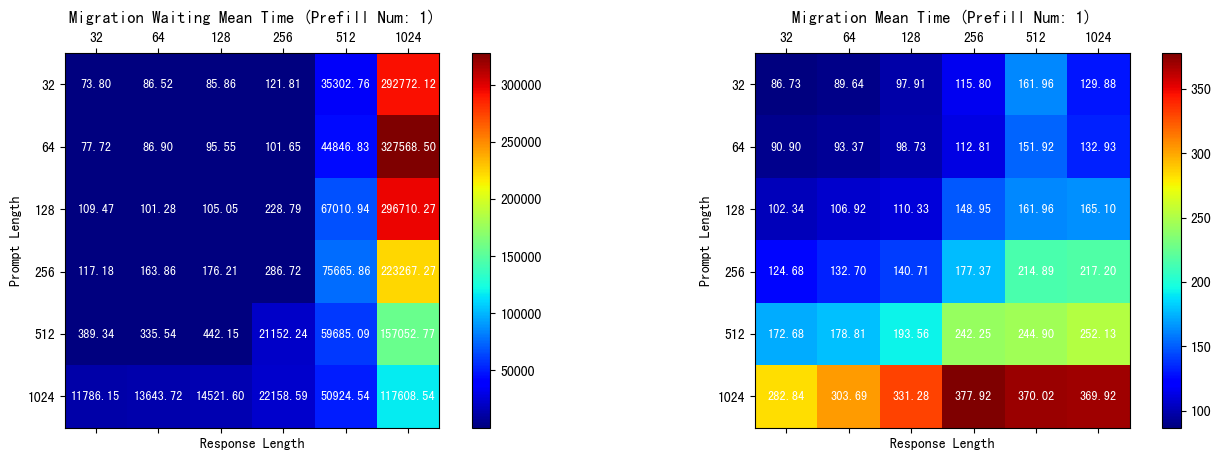

In [28]:
def get_pd_migration_times(log_dir, prompt_len, response_len, req_num, qps, instance_num, prefill_num=0, decede_num=0,time_metric='migration_waiting_time'):
    if prefill_num == 0 and decede_num == 0:
        log_filename = f'benchmark_{instance_num}_tp{tp}_{req_num}_qps_{qps}_prompt_len_{prompt_len}_response_len_{response_len}_all_decode_token_latencies.csv'
    else:
        log_filename = f'benchmark_pdd_tp{tp}_{req_num}_qps_{qps}_prompt_len_{prompt_len}_response_len_{response_len}_{prefill_num}_{decede_num}_all_decode_token_latencies.csv'
    log_filename = os.path.join(log_dir, log_filename)
    with open(log_filename, 'r') as f:
        return np.mean(pd.read_csv(log_filename)[time_metric])
prompt_lens = [32, 64, 128, 256, 512, 1024]     # [32, 64, 128, 256, 512, 1024]
response_lens = [32, 64, 128, 256, 512, 1024]
instance_num = 2
migration_waiting_mean_time = np.zeros((len(prompt_lens), len(response_lens), instance_num-1))
migration_mean_time = np.zeros((len(prompt_lens), len(response_lens), instance_num-1))
tp = 1
req_num = 1000
qps = 4
model='llama-2-7b'
distribution= 'poisson'
migrate_backend = 'nccl'
log_dir = f'/workspace/llm-serve/Llumnix/logs/l40-pdd---{instance_num}/{model}/{distribution}/{migrate_backend}'
for i, prompt_len in enumerate(prompt_lens):
    for j, response_len in enumerate(response_lens):
        for prefill_num in range(1,instance_num):
            decede_num = instance_num - prefill_num
            tmp = get_pd_migration_times(log_dir, prompt_len, response_len, req_num, qps, instance_num, prefill_num,decede_num)
            migration_waiting_mean_time[i][j][prefill_num-1] = tmp
            tmp = get_pd_migration_times(log_dir, prompt_len, response_len, req_num, qps, instance_num, prefill_num,decede_num,'migration_time')
            migration_mean_time[i][j][prefill_num-1] = tmp

print(migration_waiting_mean_time)
print(migration_mean_time)
fig, axes = plt.subplots(instance_num-1, 2, figsize=(2*7, (instance_num-1)*4.8, ))
if isinstance(axes, matplotlib.axes.Axes):
    axes = [axes]
else:
    axes = axes.flatten()  # 将二维数组展平为一维数组

for i in range(instance_num-1):
    data = migration_waiting_mean_time[:, :, i]
    title = f'Migration Waiting Mean Time (Prefill Num: {i+1})'
    ax = axes[i*2]
    plot_heatmap(data, title, response_lens, prompt_lens, ax)
    ax.set_xlabel('Response Length')
    ax.set_ylabel('Prompt Length')
    ax.set_title(title)

    data = migration_mean_time[:, :, i]
    title = f'Migration Mean Time (Prefill Num: {i+1})'
    ax = axes[i*2+1]
    plot_heatmap(data, title, response_lens, prompt_lens, ax)
    ax.set_xlabel('Response Length')
    ax.set_ylabel('Prompt Length')
    ax.set_title(title)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
fig.savefig("migration_time.png")
plt.close(fig)
        

## 解析 per_token_latency_breakdown_list

查看单个request的各个token生成过程中的关键时间戳

In [21]:
migrate_backend = 'rayrpc'
json_file = '/workspace/llm-serve/Llumnix/logs/l40-pdd--2/llama-2-7b/uniform/' + migrate_backend + '/benchmark_pdd_tp1_10_qps_4_prompt_len_256_response_len_128_1_1_latency_info.json'
with open(json_file, 'r') as f:
    data = json.load(f)
per_token_latency_breakdown_list = data[0]['per_token_latency_breakdown_list']
for req_idx in range(10):
    df = pd.DataFrame(per_token_latency_breakdown_list[req_idx])
    print(data[0]['request_ids'][req_idx])
    df.head(n=128)
    df.to_csv(os.path.join('/workspace/llm-serve/Llumnix/logs/l40-pdd--2/llama-2-7b/uniform/' + migrate_backend, f'request_{req_idx}_timestamps.csv'), index=True)

0348f1cc6f684b18bc3a86134172c3ca
7e580e24561f4cc6bc6c4374c0dbb0d0
6111d0f56cb84bdeb30bc6f7e6fc075d
cb9cff75a8a34fd89598a41a45b6c58f
84e09df27f384ce690a4a5427c6e621f
3dc38521fb1045bcb92bd2d1c5ca8799
6a9df51ebf174fbcaa40166b2264282c
15152624685949618bd622679ff1f29a
4e41e4e6c06e466fa904d7fc2d80301c
f389c8d6bd97487e952e841c77a66a4e
